In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
import urllib.request

from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
# 파일 불러오기
review = pd.read_csv('naver_movie_content_0404.csv', low_memory=False, encoding = 'UTF-8')
review.head()

,movie,sentence,score
0,터미네이터 제니시스,1991년의 상상력을 못이기네,7
1,극장판 금빛 모자이크: 땡큐!!,영화 금빛 모자이크 땡큐 잘 봤습니다.,10
2,파송송 계란탁,아이가 연기를 너무 못하네요. 투박하고 부자연스러웠습니다. 임창정이 연기로 어떻게든...,2
3,그린랜드,발암 모먼트 탑2. &amp;#34;(군인한테)아까 저희 남편이랑 얘기 하는거 봤어...,1
4,모비우스,독약은 두 개 만들고 왜 친구만 보내요ㅜ..,8


<AxesSubplot:>

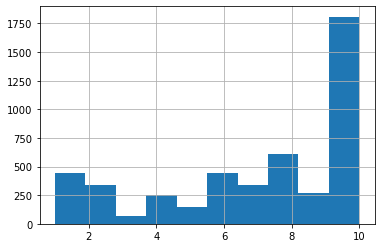

In [24]:
review.score.hist()

### 긍정/부정 라벨링하기

In [25]:
#긍부정 라벨링하기
# 긍정이 1, 부정이 0
#8점 이상을 긍정, 8점 미만을 부정

review['label'] = 0
review.loc[review['score'] >= 8, 'label'] = 1
review.head()

,movie,sentence,score,label
0,터미네이터 제니시스,1991년의 상상력을 못이기네,7,0
1,극장판 금빛 모자이크: 땡큐!!,영화 금빛 모자이크 땡큐 잘 봤습니다.,10,1
2,파송송 계란탁,아이가 연기를 너무 못하네요. 투박하고 부자연스러웠습니다. 임창정이 연기로 어떻게든...,2,0
3,그린랜드,발암 모먼트 탑2. &amp;#34;(군인한테)아까 저희 남편이랑 얘기 하는거 봤어...,1,0
4,모비우스,독약은 두 개 만들고 왜 친구만 보내요ㅜ..,8,1


In [26]:
review.drop(['movie', 'score'], axis = 1, inplace = True)

In [27]:
review

,sentence,label
0,1991년의 상상력을 못이기네,0
1,영화 금빛 모자이크 땡큐 잘 봤습니다.,1
2,아이가 연기를 너무 못하네요. 투박하고 부자연스러웠습니다. 임창정이 연기로 어떻게든...,0
3,발암 모먼트 탑2. &amp;#34;(군인한테)아까 저희 남편이랑 얘기 하는거 봤어...,0
4,독약은 두 개 만들고 왜 친구만 보내요ㅜ..,1
...,...,...
4714,역시나 내 스타일 아님,0
4715,에효 주혁이형... 잘 있쟈?,0
4716,자레드 레토의 모비우스는 진짜 쩔었음 이 분 팬 될 것 같은 느낌 ㅋㅋ,1
4717,마틴.... 그녀의 명석한 두뇌와 귀여운 고양이에 제대로 치이고 갑니다....,1


### py-hanspell(맞춤법, 띄어쓰기 검사기) 적용하기

In [30]:
# Null 값이 한개라도 존재하는 행 제거
review = review.dropna(how = 'any') 

In [31]:
from hanspell import spell_checker

new_sent = []
def review_sent(text):
    for i in range(len(text)):
        spelled_sent = spell_checker.check(text[i])
        hanspell_sent = spelled_sent.checked
        sent = hanspell_sent
        new_sent.append(sent)

In [32]:
review_sent(review['sentence'])

JSONDecodeError: Invalid control character at: line 1 column 128 (char 127)

In [ ]:
review['sentence'] = new_sent
review.head()

In [ ]:
df_review = review['sentence']
df_review

### 전처리

In [ ]:
#영어 소문자로 모두 변환
df_review = df_review.str.lower()

In [ ]:
#반복되는 문자 제거하기

df_review = df_review.str.replace("ㅋ","") # ㅋㅋㅋ제거
df_review = df_review.str.replace("ㅜ","") # ㅜㅜㅜ제거
df_review = df_review.str.replace("ㅠ","") # ㅠㅠㅠ제거
df_review = df_review.str.replace("ㅎ","") # ㅎㅎㅎ제거
df_review = df_review.str.replace("ㅇ","") # ㅇㅇ제거
df_review = df_review.str.replace("ㄷ","") # ㄷㄷ제거
df_review = df_review.str.replace("ㄱ","") # ㄱㄱ제거
df_review = df_review.str.replace("-","") # --제거
df_review = df_review.str.replace("_","") # __제거
df_review = df_review.str.replace("ㅡ","") # ㅡㅡ제거
df_review = df_review.str.replace("ㅉ","")
df_review = df_review.str.replace("ㅆㅈ","")
df_review = df_review.str.replace("ㅏ","")
df_review = df_review.str.replace("ㅡ","")

In [ ]:
#인터넷 줄임말 단어 변환해주기
df_review = df_review.str.replace("ㄱㅊ","괜찮")
df_review = df_review.str.replace("ㅈㄹ","지랄")
df_review = df_review.str.replace("ㅈㅁ","정말")
df_review = df_review.str.replace("ㅇㅈ","인정")
df_review = df_review.str.replace("ㄹㅇ","정말")
df_review = df_review.str.replace("ㅈㅅ","죄송")
df_review = df_review.str.replace("좋ㅈ었습니다","좋았습니다")
df_review = df_review.str.replace("ㅈㄴ","존나")

#영어표현 변경
df_review = df_review.str.replace("cg","씨지")
df_review = df_review.str.replace("ost","오에스티")
df_review = df_review.str.replace("sf","공상과학")
df_review = df_review.str.replace("tv","텔레비전")
df_review = df_review.str.replace("sns","소셜미디어")
df_review = df_review.str.replace("good","좋다")
df_review = df_review.str.replace("best","좋다")

#불용어 삭제
df_review = df_review.str.replace("영화","")

In [ ]:
#정규표현식 
df_review = df_review.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
df_review = df_review.str.replace('^ +', "") #공백은 empty값으로 변경
#df_review.drop_duplicates(subset = ['content'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
df_review.replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
df_review = df_review.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(df_review))

In [ ]:
#전처리 데이터 다시 넣어주기
review['sentence'] = df_review

In [ ]:
# Null 값이 한개라도 존재하는 행 제거
review = review.dropna(how = 'any') 

### 형태소분석기_Okt사용

In [33]:
from konlpy.tag import Okt
import io
from konlpy.utils import pprint
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import urllib.request 
import time

okt = Okt()

In [ ]:
import konlpy
print(konlpy.__version__)

In [ ]:
#리뷰 데이터 형태소분석 및 태깅
review_tag = []

for sentence in tqdm(review['sentence']):
    tokenized_sentence = okt.pos(sentence, stem = True) # 토큰화
    review_tag.append(tokenized_sentence)

In [ ]:
review['tagging'] = review_tag

In [ ]:
review.head()

In [ ]:
tag = review["tagging"]

In [ ]:
# 동사, 명사, 형용사 태깅된 단어들만 선별하여 저장하기
#words_list = []
#for sentence1 in review_tag:
#    for word, tag in sentence1:
#        if tag in ['Noun','Adjective','Verb']:
#            words_list.append(word)

In [ ]:
review_new = []

for sentence in tqdm(review['sentence']):
    tokenized_sentence = okt.pos(sentence, stem = True) # 토큰화
    words_list_sentence = [word for word, tag in tokenized_sentence if tag in ['Noun','Adjective','Verb']] 
    review_new.append(words_list_sentence)

In [ ]:
review['tag_list'] = review_new

In [34]:
#단어 카운트하기
from collections import Counter
counts = Counter(words_list)
print(counts.most_common(30))

NameError: name 'words_list' is not defined

### Train data, Test data split

In [ ]:
train_data = review['tag_list']
test_data = review['label'].values

In [ ]:
train_data.shape

In [ ]:
train_data.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_data, test_data, test_size = 0.2, random_state = 422)

In [ ]:
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape}')

### 단어의 길이 분포 확인

In [ ]:
positive_words = np.hstack(review[review.label == 1]['tag_list'].values)
negative_words = np.hstack(review[review.label == 0]['tag_list'].values)

In [ ]:
from collections import Counter

# 긍정리뷰에 많이 나오는 단어 (100개)
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(100))

In [ ]:
# 부정리뷰에 많이 나오는 단어 (100개)
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(100))

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = review[review['label']==1]['tag_list'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = review[review['label']==0]['tag_list'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

### 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

In [ ]:
# 전체 단어 개수 중 빈도수 1 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

In [ ]:
Y_train

In [ ]:
X_train

### 빈샘플(empty samples)제거

In [ ]:
# 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스 추출
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
len(drop_train)

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
Y_train = np.delete(Y_train, drop_train, axis=0)
print(len(X_train))
print(len(Y_train))

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
# 최대 길이가 133이므로 만약 30으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인
max_len = 30
below_threshold_len(max_len, X_train)

### Padding

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
X_train

In [35]:
X_test

NameError: name 'X_test' is not defined

In [ ]:
Y_train

In [ ]:
Y_test

In [ ]:
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape}')

### Create Model

In [ ]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPool1D, MaxPooling2D, Flatten, Conv2D, MaxPooling1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout # Permute : 주어진 패턴에 따라서 입력 차수 변경
from tensorflow.keras.layers import add, dot, concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
# CNN를 사용한 모델 (model1) 정의
embedding_dim = 100
hidden_units = 128

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model1.add(Conv1D(256, kernel_size = 3, padding = 'SAME', activation = 'relu', input_shape = (10, 4)))
model1.add(Conv1D(128, kernel_size = 3, padding = 'SAME', activation = 'relu'))
model1.add(Conv1D(64, kernel_size = 3, padding = 'SAME', activation = 'relu'))
model1.add(MaxPooling1D(pool_size = 2))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dropout(0.3))
model1.add(Dense(100, activation = 'relu'))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))
    
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('review_best_model_10.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model1.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc']) # adam
model1.summary()

In [ ]:
# LSTM를 사용한 모델 (model2) 정의
embedding_dim = 100
hidden_units = 128

model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim))
model2.add(LSTM(hidden_units))
model2.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('review_best_model_8.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc']) # adam
model2.summary()

In [ ]:
r1 = model1.fit(X_train, Y_train, epochs = 30, callbacks = [es, mc], batch_size = 64, validation_data = (X_test, Y_test))

In [ ]:
r2 = model2.fit(X_train, Y_train, epochs = 15, callbacks = [es, mc], batch_size = 64, validation_data = (X_test, Y_test))

In [ ]:
loaded_model = load_model('review_best_model_10.h5') # 정확도 85.51%
loaded_model.evaluate(X_test, Y_test)

In [ ]:
loaded_model = load_model('review_best_model_8.h5') # 정확도 85.29%
loaded_model.evaluate(X_test, Y_test)

### Evaluate the Model

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(r1.history.keys())

In [ ]:
plt.plot(r1.history['acc'])
plt.plot(r1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### 예측

In [ ]:
review1 = "솔직히 두 주인공의 감정이입이 안되다보니 아무느낌 없습니다"

In [ ]:
from hanspell import spell_checker
def review_predict(review1):
    
    # 1. spell_checker
    spelled_sent = spell_checker.check(review1)
    hanspell_sent = spelled_sent.checked
    new_review = hanspell_sent
    
    # 2. 반복되는 문자 제거하기
    new_review = new_review.replace("ㅋ","") # ㅋㅋㅋ제거
    new_review = new_review.replace("ㅜ","") # ㅜㅜㅜ제거
    new_review = new_review.replace("ㅠ","") # ㅠㅠㅠ제거
    new_review = new_review.replace("ㅎ","") # ㅎㅎㅎ제거
    new_review = new_review.replace("ㅇ","") # ㅇㅇ제거
    new_review = new_review.replace("ㄷ","") # ㄷㄷ제거
    new_review = new_review.replace("ㄱ","") # ㄱㄱ제거
    new_review = new_review.replace("-","") # --제거
    new_review = new_review.replace("_","") # __제거
    new_review = new_review.replace("ㅡ","") # ㅡㅡ제거

    new_review = new_review.replace("ㅉ","")
    new_review = new_review.replace("ㅆㅈ","")
    new_review = new_review.replace("ㅏ","")
    new_review = new_review.replace("ㅡ","")
    
    # 3. 단어 변환해주기 - 줄임말 변경
    new_review = new_review.replace("ㄱㅊ","괜찮")
    new_review = new_review.replace("ㅈㄹ","지랄")
    new_review = new_review.replace("ㅈㅁ","정말")
    new_review = new_review.replace("ㅇㅈ","인정")
    new_review = new_review.replace("ㄹㅇ","정말")
    new_review = new_review.replace("ㅈㅅ","죄송")
    new_review = new_review.replace("좋ㅈ었습니다","좋았습니다")
    new_review = new_review.replace("ㅈㄴ","존나")

    # 4. 영어표현 변경
    new_review = new_review.replace("cg","씨지")
    new_review = new_review.replace("ost","오에스티")
    new_review = new_review.replace("sf","공상과학")
    new_review = new_review.replace("tv","텔레비전")
    new_review = new_review.replace("sns","소셜미디어")
    new_review = new_review.replace("good","좋다")
    new_review = new_review.replace("best","좋다")
    
    # 5. 한글과 공백을 제외하고 모두 제거 
    new_review = new_review.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

    # 6. 토큰화
    new_review = okt.pos(new_review, stem = True) 
    new_review = [word for word, tag in new_review if tag in ['Noun','Adjective','Verb']] 
    
    # 7. Embedding 처리 (text -> sequences)
    new_review = tokenizer.texts_to_sequences([new_review])

    # 8. padding -> 길이 값을 맞추기 위해 
    padding_review = pad_sequences(new_review, maxlen = max_len)

    # 9. predcit 
    score = float(loaded_model.predict(padding_review))

    # 10. 결과 값 판단 
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰".format((1- score) * 100))

In [ ]:
review_predict("솔직히 두 주인공의 감정이입이 안되다보니 아무느낌 없습니다")
# sequential -> 96.00% 확률로 부정 리뷰

In [ ]:
review_predict("정겨운 사람과 따뜻한 공간을 떠나온 지금도 가슴 속에 추억한다.")
# sequential -> 99.76% 확률로 긍정 리뷰

In [ ]:
review_predict("멸공이라는 단어를 악으로 만든 영화.전형적인 한국식 정치영화")
# sequential -> 63% 확률로 부정 리뷰